In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MIRNet-master

/content/drive/MyDrive/MIRNet-master


In [3]:
!pip install -qq wandb

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 170 kB 46.2 MB/s 
     |████████████████████████████████| 133 kB 47.4 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [4]:
from glob import glob
import tensorflow as tf
from mirnet.train import LowLightTrainer
from mirnet.utils import init_wandb, download_dataset
from mirnet.inference import Inferer
from mirnet.utils import download_dataset, plot_result

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
init_wandb(
    project_name='mirnet',
    experiment_name='LOL_lowlight_experiment_2_256x256',
    wandb_api_key='cf0947ccde62903d4df0742a58b8a54ca4c11673'
)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


In [ ]:
trainer = LowLightTrainer()
train_low_light_images = glob('./our485/low/*')
train_high_light_images = glob('./our485/high/*')
valid_low_light_images = glob('./eval15/low/*')
valid_high_light_images = glob('./eval15/high/*')

In [ ]:
trainer.build_dataset(
    train_low_light_images, train_high_light_images,
    valid_low_light_images, valid_high_light_images,
    crop_size=256, batch_size=2
)
trainer.compile()

In [ ]:
trainer.train(epochs=100, checkpoint_dir='./checkpoints')

In [5]:
inferer = Inferer()

inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='checkpoints/low_light_weights_best.h5'
)

In [6]:
from PIL import Image

def resize_image(path):
  im = Image.open(path)
  newsize = (600, 400)
  im = im.resize(newsize)
  im.save(path)
  return path

In [7]:
#Importing Library
import cv2
from google.colab.patches import cv2_imshow
import numpy

def face_detact(output_image):
  #Load Cascade
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  # use numpy to convert the pil_image into a numpy array
  numpy_image=numpy.array(output_image)  

  # convert to a openCV2 image, notice the COLOR_RGB2BGR which means that 
  opencv_image=cv2.cvtColor(numpy_image, 0) 

  #Load image
  our_image_color = opencv_image

  #Detect face
  faces = face_cascade.detectMultiScale(our_image_color,scaleFactor = 1.05,minNeighbors = 15)

  try:
    for x, y, w, h in faces:
      our_image_rect = cv2.rectangle(our_image_color, (x,y), (x+w,y+h), (0,255,0), 3)

    return our_image_rect
  except:
    return output_image


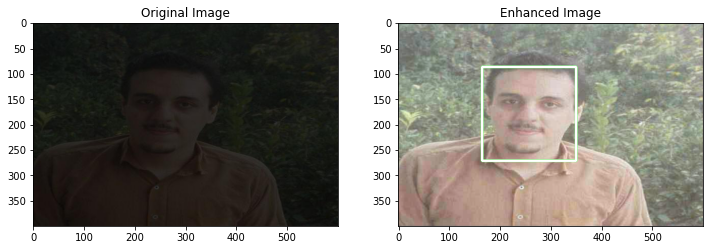

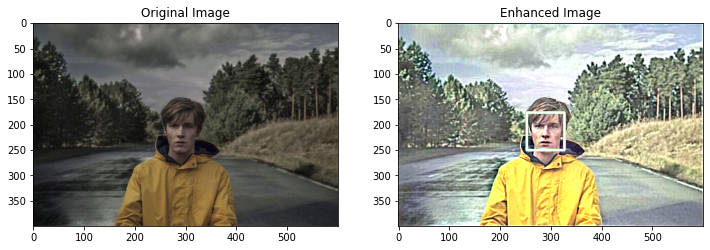

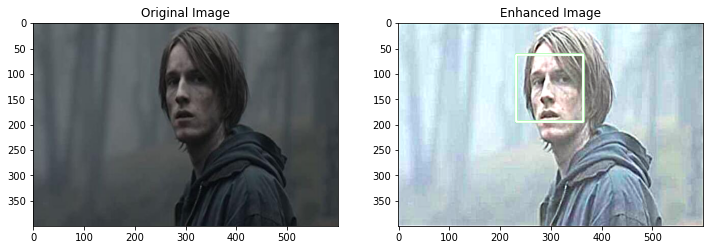

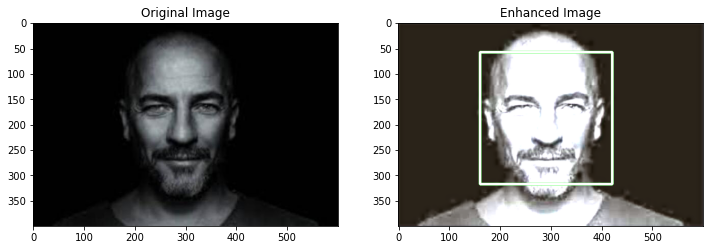

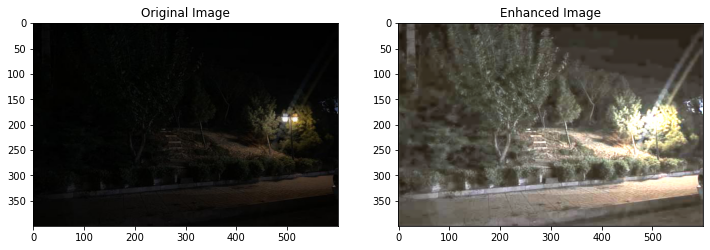

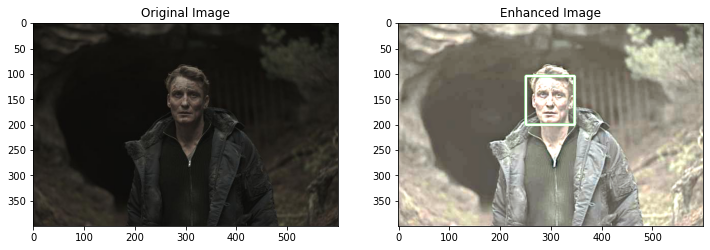

In [8]:
import random

low_light_images = glob('./test_images/*')
for image_path in random.sample(low_light_images, 6):
    original_image, output_image = inferer.infer(resize_image(image_path))
    plot_result(original_image, face_detact(output_image))